> RNN 모델: 자연어 처리에 특화됨

# 환경설정

### 패키지 설치 및 임포트

In [1]:
!pip uninstall torch -y


Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1


In [2]:
!pip cache purge


Files removed: 2


In [3]:
!pip install scikit-learn==1.3.0 -q
!pip install torch==2.0.1 -q
!pip install torchvision==0.15.2 -q
!pip install torchtext==0.15.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.9 MB/s eta 0:00:00


In [4]:
!python --version


Python 3.10.12


In [1]:
# !pip install scikit-learn
# !pip install torch
# !pip install torchvision
# !pip install torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [6]:
import numpy as np # 기본적인 연산을 위한 라이브러리
import matplotlib.pyplot as plt # 그림이나 그래프를 그리기 위한 라이브러리
from tqdm.notebook import tqdm # 상태 바를 나타내기 위한 라이브러리
import pandas as pd # 데이터프레임을 조작하기 위한 라이브러리

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.optim as optim # optimizer 설정을 위한 라이브러리
from torch.utils.data import Dataset, DataLoader # 데이터셋 설정을 위한 라이브러리
import torch.nn.functional as F # torch에서 수학적인 function을 쉽게 불러오기 위한 라이브러리

from torchtext.data import get_tokenizer # torch에서 tokenizer를 얻기 위한 라이브러리
import torchtext # torch에서 text를 더 잘 처리하기 위한 라이브러리

from sklearn.metrics import accuracy_score # 성능지표 측정
from sklearn.model_selection import train_test_split # train-validation-test set 나누는 라이브러리

import re # text 전처리를 위한 라이브러리

In [7]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [8]:
device = 'cuda:0'
# device = torch.device('cpu')

### 데이터셋 개요


* 데이터셋: <a href='https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset'>Medium Dataset</a>
* 데이터셋 개요: "Towards Data Science", "UX Collective", "The Startup", "The Writing Cooperative", "Data Driven Investor", "Better Humans", "Better Marketing" 의 7개의 주제를 가지는 publication 에 대해서 크롤링을 한 데이터입니다. 원본 데이터는 총 6,508개의 블로그 이미지와 메타 데이터(.csv)로 구성됩니다. 실습에서는 메타데이터를 사용하여 CustomDataset을 구현합니다.
  * [How to collect ths dataset?](https://dorianlazar.medium.com/scraping-medium-with-python-beautiful-soup-3314f898bbf5)
- 메타 데이터 스키마: 메타 데이터는 총 **10**개의 column으로 구성됩니다.
  - id: 아이디
  - url: 포스팅 링크
  - title: 제목
  - subtitle: 부제목
  - image: 포스팅 이미지의 파일 이름
  - claps: 추천 수
  - reponses: 댓글 수
  - reading_time: 읽는데 걸리는 시간
  - publication: 주제 카테고리(e.g. Towards Data Science..)
  - date: 작성 날짜
- 데이터 셋 저작권: CC0: Public Domain

# 1.Vanilla RNN


## 1.1 Vanilla RNN 모델 구현하기

> `torch.nn.RNN`을 통해 RNN 모델을 구현

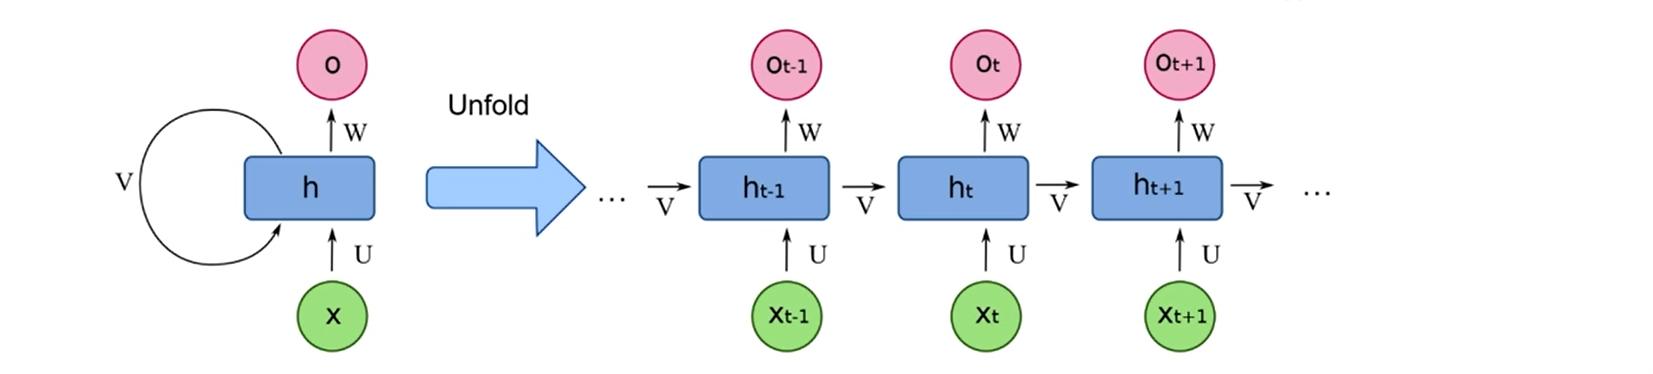

[이미지 출처](https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D)

### Vanilla RNN이란?

* RNN 모델은 recurrent neural network로 입력과 출력을 sequence 단위로 처리하는 모델입니다.
  * sequence는 순서대로 배열된 데이터들의 집합으로 순차적으로 연결되어 있고, 각 항목은 특정 순서에 따라 나열되어 있습니다.
  * ex)  "Hello, how are you?"라는 문장은 "Hello", ",", "how", "are", "you", "?"라는 단어들이 순서대로 나열되어 있는 sequence 입니다.
* DNN과 달리 RNN은 시간의 흐름에 따라 정보를 공유할 수 있으며, 이로 인해 이전 단계에서 얻은 정보가 현재 단계에서 영향을 미치게 됩니다.
* RNN은 이전 단계의 은닉 상태(hidden states)와 현재 입력을 사용하여 다음 단계의 은닉 상태를 계산하는 방식으로 구성이 되어, 과거의 정보와 현재의 정보를 모두 이용하는 방식으로 구현되어 있습니다.
  * 처음에는 zero-vector로 초기화 되거나 random으로 초기화 됩니다.

* [RNN 설명](https://wikidocs.net/22886)

### Next word prediction을 위한 데이터셋을 구현
* DNN 구현(3)에서 다뤘던 데이터셋으로 custom dataset class를 구현합니다.


* [데이터 다운로드](https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset)

In [9]:
# DNN 에서 갖고 오기
data_csv = pd.read_csv('medium_data.csv')
data = data_csv['title']

같은 데이터를 사용한 이전 내용(DNN 구현(3))과 동일한 코드

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, vocab, tokenizer, max_len):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len
        self.tokenizer = tokenizer
        seq = self.make_sequence(self.data, self.vocab, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
        self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌
        self.X = torch.tensor(self.seq[:,:-1])
        self.label = torch.tensor(self.seq[:,-1])

    def make_sequence(self, data, vocab, tokenizer):
        seq = []
        for i in data:
            token_id = vocab.lookup_indices(tokenizer(i))
            for j in range(1, len(token_id)):
                sequence = token_id[:j+1]
                seq.append(sequence)
        return seq

    def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
        return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])


    def __len__(self): # dataset의 전체 길이 반환
        return len(self.X)

    def __getitem__(self, idx): # dataset 접근
        X = self.X[idx]
        label = self.label[idx]

        return X, label

In [11]:
def cleaning_text(text):
    cleaned_text = re.sub( r"[^a-zA-Z0-9.,@#!\s']+", "", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
    cleaned_text = cleaned_text.replace(u'\xa0',u' ') # No-break space를 unicode 빈칸으로 변환
    cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
    return cleaned_text

In [12]:
# from torchtext.vocab import build_vocab_from_iterator

data = list(map(cleaning_text, data))
tokenizer = get_tokenizer("basic_english")

vocab = torchtext.vocab.build_vocab_from_iterator(map(tokenizer, data))
vocab.insert_token('<pad>',0)
max_len = 20

In [13]:
# train set과 validation set, test set을 각각 나눕니다. 8 : 1 : 1 의 비율로 나눕니다.
train, test = train_test_split(data, test_size = .2, random_state = 42)
val, test = train_test_split(test, test_size = .5, random_state = 42)
print("Train 개수: ", len(train))
print("Validation 개수: ", len(val))
print("Test 개수: ", len(test))

train_dataset = CustomDataset(train, vocab, tokenizer, max_len)
valid_dataset = CustomDataset(val, vocab, tokenizer, max_len)
test_dataset = CustomDataset(test, vocab, tokenizer, max_len)

Train 개수:  5206
Validation 개수:  651
Test 개수:  651


In [14]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

### PyTorch에서의 RNN 구현은 어떻게 할까?
* RNN은 `torch.nn.RNN`을 통해 쉽게 구현할 수 있습니다.
* torch.nn.RNN은 t시점의 hidden state를 계산해주는 역할을 합니다.
* torch.nn.RNN은 기본적으로 `input_size`와 `hidden_size`를 지정해줘야합니다.
  * `input_size`: embedding dimension
  * `hidden_size`: hidden state dimension

* [PyTorch RNN 공식 document](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

### Next word prediction를 위한 RNN 모델 구현
* Next word prediction 작업에서는 주어진 입력 시퀀스로부터 다음 단어를 예측하는 것이 목표입니다.
* 이때, 일반적으로 주어진 시퀀스 내에서 **마지막 time step의 hidden state**를 사용합니다.
  * RNN은 이전 time step의 정보를 현재 time step으로 전달하는 방식이기 때문에, 모든 이전 time step의 정보를 담고 있는 마지막 time step의 hidden state를 사용하면 문맥 정보를 잘 반영할 수 있습니다.
* torch.RNN의 output은 모든 time step의 정보를 담고 있는 hidden state와 마지막 time_step의 정보만 담고 있는 hidden state 두개를 반환합니다.
  * 여기서 우리는 코딩의 편리성을 위해, 모든 정보를 담고 있는 hidden state를 사용하여 마지막 time_step의 정보만 따로 추출합니다.
  * 마지막 time_step의 정보만 담고 있는 hidden state의 shape은 RNN의 layer 개수와 나중에 학습하는 bidirectional 인자에 의해 영향을 받기 때문입니다.

> 모델구현

In [15]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(RNN, self).__init__()
        # 각 단어를 RNN 셀에 넣기전에 임베딩 해주어야 함 : 임베딩 레이어 생성 > 이 후 각 단어들을 RNN에 넣어서 순차적으로 처리
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # RNN 을 통해서 받은 마지막 hidden state 벡터를 classifier 에 넣기 위해서 self.fc = nn.Linear(hidden_size, vocab_size) 를 구현
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True) # batch_first=True는 입력의 첫 번째 차원이 batch 크기임을 나타냅니다.

        # Output을 vocab 사이즈만큼 뱉어줌. Vocap 사이즈 중 가장 큰 값을 갖는 단어를 다음 단어로
        self.fc = nn.Linear(hidden_size, vocab_size)


    '''
    # 인풋으로 들어오는 것은 미니배치 만큼 묶여서 들어오는데, 그것이 각각 sequence max length 만큼 채워져 있음
    # 이것을 임베딩 레이어를 진행해 주면
    # [batch_size, sequence_len, embedding_dim] 이런 SHAPE 가지는 임베딩 벡터가 형성이 되고
    # 그 임베딩 벡터를 그대로 RNN 셀에 넣어주면
    # 아래와 같이 output을 받아올 수 있다
    # output, return 2개의 출력값을 가지고 있다.
    '''
    def forward(self, x):
        '''
        INPUT:
           x: [batch_size, seq_len]
        OUTPUT:
           output: [batch_size, vocab_size]
        '''
        x = self.embedding(x) # [batch_size, sequence_len, embedding_dim]

        # 첫 번째 리턴값인 output은 모든 time step의 hidden state를 포함(마지막 값이 h_0 도 포함)한 출력입니다.
        # 두 번째 리턴값인 h_0 는 마지막 time step의 hidden state를 의미합니다.
        output, h_0 = self.rnn(x) # output: [batch_size, seq_len, hidden_dim] / h_0: [1, batch_size, hidden_dim]
        return self.fc(output[:,-1,:]) # [batch_size, vocab_size]

## 1.2 훈련 및 평가

> 학습 및 평가 코드를 직접 작성하고, 다음에 나올 단어를 예측할 수 있는 추론 코드를 작성

### 학습 및 평가하기
* RNN의 학습 방법은 앞서 배웠던 DNN, CNN과 동일하게 진행됩니다.

In [16]:
# training 코드, evaluation 코드, training_loop 코드
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(dataloader)
    for texts, labels in tbar:
        texts = texts.to(device)
        labels = labels.to(device)
        # 순전파

        outputs = model(texts)

        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실과 정확도 계산
        train_loss += loss.item()
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs, dim=1)


        train_accuracy += (predicted == labels).sum().item()

        # tqdm의 진행바에 표시될 설명 텍스트를 설정
        tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    # 에폭별 학습 결과 출력
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, dataloader, valid_dataset, criterion, device, epoch, num_epochs):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for texts, labels in tbar:
            texts = texts.to(device)
            labels = labels.to(device)

            # 순전파
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            valid_loss += loss.item()
            # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
            _, predicted = torch.max(outputs, 1)
            # _, true_labels = torch.max(labels, dim=1)
            valid_accuracy += (predicted == labels).sum().item()


            # tqdm의 진행바에 표시될 설명 텍스트를 설정
            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

    valid_loss = valid_loss / len(dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, train_dataset, val_dataset, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, val_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return model, valid_max_accuracy

In [17]:
num_epochs = 100
patience = 3
model_name = 'RNN'

vocab_size = len(vocab)
embedding_dim = 512
hidden_size = 256
model = RNN(vocab_size, embedding_dim, hidden_size).to(device)

lr = 1e-3
# 위 RNN 모델 구현에서 SoftMax가 빠져있음. 그래서 손실함수로 NLLoss 가 아닌, CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
print('Valid max accuracy : ', valid_max_accuracy)

  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 7.0219, Train Accuracy: 0.1112 Valid Loss: 6.8262, Valid Accuracy: 0.1321


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 5.3988, Train Accuracy: 0.1653 Valid Loss: 6.9667, Valid Accuracy: 0.1368


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 4.2825, Train Accuracy: 0.2262 Valid Loss: 7.2120, Valid Accuracy: 0.1313


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 3.3855, Train Accuracy: 0.3309 Valid Loss: 7.4870, Valid Accuracy: 0.1260
Early stopping
Valid max accuracy :  0.13676656817222457


### Next word prediction 평가
* 학습한 RNN 모델을 accuracy score로 평가

In [18]:
model.load_state_dict(torch.load("./model_RNN.pt")) # 모델 불러오기
model = model.to(device)
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    for texts, labels in tqdm(test_dataloader):  # for 문을 적용해서 test 데이터를 불러옴
        texts = texts.to(device)
        labels = labels

        outputs = model(texts)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        total_preds.extend(predicted.detach().cpu().tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
nwp_rnn_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("Next word prediction RNN model accuracy : ", nwp_rnn_acc)

  0%|          | 0/143 [00:00<?, ?it/s]

Next word prediction RNN model accuracy :  0.12817147856517935


# 2.LSTM

기본적인 LSTM 구조를 이해하고, 이를 PyTorch로 LSTM 모델을 구축

## 2.1 LSTM 모델 구현하기

> `torch.nn.LSTM`을 통해 LSTM 모델을 구현

### LSTM이란?

* LSTM (Long Short-Term Memory)의 약자로 RNN의 단점인 장기 의존성 문제를 해결하기 위해 고안된 모델입니다.
  * RNN의 장기 의존성 문제: 시퀀스가 길어질수록 앞부분의 정보가 뒷부분의 예측에 영향을 미치기 어려운 문제

<!-- * LSTM의 게이트
  * Input gate: 새로운 입력을 기억하는데 사용됩니다. 이 게이트는 어떤 정보를 얼마만큼 기억할지 결정하는 역할을 합니다.

  * Forget gate: 과거 정보를 얼마만큼 삭제할지 결정하는 역할을 합니다. 이를 통해 불필요한 정보를 제거하고 장기 의존성 문제를 완화합니다.

  * Output gate: 현재 시점의 은닉 상태를 계산하는데 사용됩니다. LSTM이 다음 시점으로 얼마만큼 정보를 전달할지 결정하는 역할을 합니다. -->


* [LSTM paper](https://dl.acm.org/doi/10.1162/neco.1997.9.8.1735)
* [LSTM 설명](https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)

### PyTorch에서의 LSTM 구현은 어떻게 할까?
* LSTM은 `torch.nn.LSTM`을 통해 쉽게 구현할 수 있습니다.
* torch.nn.LSTM RNN과 동일하게 기본적으로 `input_size`와 `hidden_size`를 지정해줘야합니다.
  * `input_size`: embedding dimension
  * `hidden_size`: hidden state dimension
* 일반적으로 RNN과 동일하게 마지막 time step의 hidden state 정보만 추출하여 사용합니다.
* torch.LSTM의 output은 모든 time step의 정보를 담고 있는 hidden state와 마지막 time_step의 정보만 담고 있는 hidden state, 그리고 마지막 time_step의 정보만 담고 있는 cell state까지 3개를 반환합니다.

* [PyTorch LSTM 공식 document](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [22]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # 앞에 코드랑 동일한데, 이 부분만 다름 : RNN -> LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        '''
        INPUT:
           x: [batch_size, seq_len]
        OUTPUT:
           output: [batch_size, vocab_size]
        '''
        x = self.embedding(x) # [batch_size, sequence_len, embedding_dim]
        # 앞의 코드(RNN)와 다른 부분
        # 마지막 hidden_state만 사용
        # lstm에선 마지막 time step에서의 cell state (c_n)도 반환합니다.
        output, (h_0, c_0) = self.lstm(x) # output : [batch_size, seq_len, hidden_dim] # h_n: [1, batch_size, hidden_dim] # c_n: [1, batch_size, hidden_dim]
        return self.fc(output[:,-1,:]) # [batch_size, num_classes]


## 2.2 훈련 및 평가

LSTM의 학습 방법은 앞서 배웠던 DNN, CNN과 동일하게 진행

### 학습 및 평가

In [23]:
num_epochs = 100
patience = 3
model_name = 'LSTM'

vocab_size = len(vocab)
embedding_dim = 512
hidden_size = 256
model = LSTM(vocab_size, embedding_dim, hidden_size).to(device)

lr = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
print('Valid max accuracy : ', valid_max_accuracy)

  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 6.9797, Train Accuracy: 0.1066 Valid Loss: 6.7091, Valid Accuracy: 0.1287


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 5.4637, Train Accuracy: 0.1732 Valid Loss: 6.7878, Valid Accuracy: 0.1454


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 4.2159, Train Accuracy: 0.2582 Valid Loss: 7.0402, Valid Accuracy: 0.1435


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 3.0822, Train Accuracy: 0.4068 Valid Loss: 7.4482, Valid Accuracy: 0.1399
Early stopping
Valid max accuracy :  0.14542000844238076


> 위에서 학습된 모델을 가지고 test set 으로 평가 진행

In [24]:
model.load_state_dict(torch.load("./model_LSTM.pt")) # 모델 불러오기
model = model.to(device)
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    for texts, labels in tqdm(test_dataloader):
        texts = texts.to(device)
        labels = labels

        outputs = model(texts)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        total_preds.extend(predicted.detach().cpu().tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
nwp_lstm_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("Next word prediction LSTM model accuracy : ", nwp_lstm_acc)

  0%|          | 0/143 [00:00<?, ?it/s]

Next word prediction LSTM model accuracy :  0.13560804899387577


# 3.GRU

> 기본적인 GRU 구조를 이해하고, 이를 PyTorch로 GRU 모델을 구현

## 3.1 GRU 모델 구현하기

> `torch.nn.GRU`을 통해 GRU 모델을 구현할 수 있습니다.

### GRU란?

* GRU (Gated Recurrent Unit)는 LSTM과 마찬가지로 장기 의존성 문제를 해결하고 RNN의 성능을 향상시키기 위해 고안된 모델입니다.
<!-- * LSTM은 3개의 게이트 (Input gate, Forget gate, Output gate)를 가지는 반면에 GRU는 2개의 게이트를 가져, LSTM보다 더욱 간단한 구조를 가집니다. -->
* GRU는 LSTM에 비하여 파라미터수가 적기 때문에 연산 비용이 적게 들고, 구조도 더 간단하지만, 성능에서도 LSTM과 비슷한 결과를 냅니다.
<!-- * GRU의 게이트
  * Reset Gate: 이전 시점의 은닉 상태와 현재 시점의 입력을 조합하여 어떤 정보를 무시할지 결정하는 역할을 합니다.

  * Update Gate: 이전 시점의 은닉 상태와 현재 시점의 입력을 조합하여 새로운 은닉 상태에 얼마나 많은 정보를 반영할지 결정하는 역할을 합니다. -->

* [GRU paper](https://arxiv.org/abs/1406.1078)
* [GRU 설명](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)

### PyTorch에서의 GRU 구현은 어떻게 할까?
* GRU는 PyTorch에 `torch.nn.GRU`을 통해 쉽게 구현할 수 있습니다.
* torch.nn.GRU RNN, LSTM과 동일하게 기본적으로 `input_size`와 `hidden_size`를 지정해줘야합니다.
  * `input_size`: embedding dimension
  * `hidden_size`: hidden state dimension
* torch.LSTM의 output은 모든 time step의 정보를 담고 있는 hidden state와 마지막 time_step의 정보만 담고 있는 hidden state 2개를 반환합니다.

* [PyTorch GRU 공식 document](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

In [26]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 앞의 코드와 다른 점 : RNN, LSTM -> GRU
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        '''
        INPUT:
           x: [batch_size, seq_len]
        OUTPUT:
           output: [batch_size, vocab_size]
        '''
        x = self.embedding(x) # [batch_size, sequence_len, embedding_dim]
        # 앞의 코드(RNN, LSTM )와 다른 부분
        output, h_0 = self.gru(x) # output : [batch_size, seq_len, hidden_dim] # h_0 는 [1, batch_size, hidden_dim]
        return self.fc(output[:,-1,:]) # [batch_size, vocab_size]

## 3.2 훈련 및 평가

> 구축한 GRU 모델을 학습하고 평가

#### 학습

In [27]:
num_epochs = 100
patience = 3
model_name = 'GRU'

vocab_size = len(vocab)
embedding_dim = 512
hidden_size = 256
model = GRU(vocab_size, embedding_dim, hidden_size).to(device)

lr = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
print('Valid max accuracy : ', valid_max_accuracy)

  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 6.9082, Train Accuracy: 0.1138 Valid Loss: 6.6684, Valid Accuracy: 0.1300


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 5.1910, Train Accuracy: 0.1856 Valid Loss: 6.8110, Valid Accuracy: 0.1437


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 3.7439, Train Accuracy: 0.2971 Valid Loss: 7.1089, Valid Accuracy: 0.1408


  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 2.4933, Train Accuracy: 0.4970 Valid Loss: 7.4660, Valid Accuracy: 0.1330
Early stopping
Valid max accuracy :  0.14373153229210636


#### 평가

In [28]:
model.load_state_dict(torch.load("./model_GRU.pt")) # 모델 불러오기
model = model.to(device)
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    for texts, labels in tqdm(test_dataloader):
        texts = texts.to(device)
        labels = labels

        outputs = model(texts)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        total_preds.extend(predicted.detach().cpu().tolist())
        total_labels.extend(labels.tolist())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
nwp_gru_acc = accuracy_score(total_labels, total_preds) # 정확도 계산
print("Next word prediction GRU model accuracy : ", nwp_gru_acc)

  0%|          | 0/143 [00:00<?, ?it/s]

Next word prediction GRU model accuracy :  0.1347331583552056


# 4.bi-directional RNN/GRU/LSTM : 양방향

> 기본적인 Bi-directional RNN/LSTM/GRU 구조를 이해하고, 이를 PyTorch로 Bi-directional RNN/LSTM/GRU 모델을 구축

## 4.1 bi-direcitional RNN/GRU/LSTM 모델 구현하기

> `bidirectional=True`를 통해 Bi-directional RNN/LSTM/GRU 모델을 구현

Bi-directional RNN이란?
<img src='https://upload.wikimedia.org/wikipedia/commons/3/35/Structural_diagrams_of_unidirectional_and_bidirectional_recurrent_neural_networks.png'></img>
* RNN/LSTM/GRU은 **과거**의 정보만 이용하여 다음을 예측하는 방식으로 구성되어 있었습니다. 그러나 Bi-directional RNN/LSTM/GRU은 **과거 뿐만 아니라 미래**의 정보를 이용하여 다음을 예측하는 방식입니다.(앞의 내용 뿐만 아니라, 뒤의 내용도 참고해서 예측)
* 예를 들어 다음과 같은 3가지 문장이 있다고 해봅시다.
  1. I'm ____.
    
    * sad, happy, hungry와 같은 다양한 단어들이 들어갈 수 있습니다.
  2. I'm ____ hungry.

   * very 또는 not과 같은 단어들이 들어갈 수 있습니다. 1번보단 들어갈 수 있는 단어가 적습니다.
  3. I'm ____ hungry, so I can eat more.
    * not 이라는 단어가 매우 적절합니다.

* 이와 같은 예시처럼, 앞의 단어들 뿐만 아니라 뒤의 단어들을 고려하여 문맥을 이해할 수 있고, 더욱 적절한 단어를 예측할 수 있습니다.


* [bi-directional RNN paper](https://ieeexplore.ieee.org/document/650093)
* [bi-directional RNN 설명](https://hyen4110.tistory.com/29)
* [이미지 출처](https://commons.wikimedia.org/wiki/File:Structural_diagrams_of_unidirectional_and_bidirectional_recurrent_neural_networks.png)
<!-- * [이미지 출처](https://d2l.ai/chapter_recurrent-modern/bi-rnn.html) -->

### PyTorch에서의 양방향 RNN/GRU/LSTM 모델은 어떻게 구현할까?
* 양방향 모델을 구현하기 위해선, `torch.nn.RNN/LSTM/GRU`의 `bidirectional` 인자를 True로 설정해주면 됩니다.
* 이 때, **양방향** RNN/GRU/LSTM이므로 hidden state의 크기가 bidirectional=False 일 때 보다 2배 더 커집니다.

In [29]:
class Bidirectional(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, model_name):
        super(Bidirectional, self).__init__()

        self.model_name = model_name # 구현할 모델의 이름을 지정해줍니다.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if self.model_name == 'bi_RNN':
            self.model = nn.RNN(embedding_dim, hidden_size, batch_first=True, bidirectional=True) # 양방향성 모델을 구축합니다.
        elif self.model_name == 'bi_LSTM':
            self.model = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        elif self.model_name == 'bi_GRU':
            self.model = nn.GRU(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size) # hidden state의 크기가 bidirectional=False 일 때 보다 2배

    def forward(self, x):
        '''
        INPUT:
           x: [batch_size, seq_len]
        OUTPUT:
           output: [batch_size, vocab_size]
        '''
        x = self.embedding(x) # [batch_size, sequence_len, embedding_dim]

        output, _ = self.model(x)
        return self.fc(output[:,-1,:]) # [batch_size, vocab_size]


## 4.2 훈련 및 평가

> bidirectional RNN/LSTM/GRU를 학습하고 평가하여 비교

### 학습

In [30]:
# training 코드, evaluation 코드, training_loop 코드
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
  model.train()  # 모델을 학습 모드로 설정
  train_loss = 0.0
  train_accuracy = 0

  for texts, labels in dataloader:
      texts = texts.to(device)
      labels = labels.to(device)

      # 순전파
      outputs = model(texts)
      loss = criterion(outputs, labels)

      # 역전파 및 가중치 업데이트
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 손실과 정확도 계산
      train_loss += loss.item()
      # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
      _, predicted = torch.max(outputs, 1)
      train_accuracy += (predicted == labels).sum().item()


  # 에폭별 학습 결과 출력
  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy / len(train_dataset)

  return model, train_loss, train_accuracy

def evaluation(model, dataloader, val_dataset, criterion, device, epoch, num_epochs):
  model.eval()  # 모델을 평가 모드로 설정
  valid_loss = 0.0
  valid_accuracy = 0

  with torch.no_grad(): # model의 업데이트 막기
      for texts, labels in dataloader:
          texts = texts.to(device)
          labels = labels.to(device)

          # 순전파
          outputs = model(texts)
          loss = criterion(outputs, labels)

          # 손실과 정확도 계산
          valid_loss += loss.item()
          # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
          _, predicted = torch.max(outputs, 1)
          valid_accuracy += (predicted == labels).sum().item()


  valid_loss = valid_loss / len(dataloader)
  valid_accuracy = valid_accuracy / len(val_dataset)

  return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, train_dataset, val_dataset, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, val_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
          valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1


        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print(f"Epoch [{epoch + 1}/{num_epochs}]")
            break

    return model, valid_max_accuracy

### 평가

In [31]:
def test(model, model_name, test_dataloader, device):
    model.load_state_dict(torch.load(f"./model_{model_name}.pt")) # 모델 불러오기
    model = model.to(device)
    model.eval()
    total_labels = []
    total_preds = []
    total_probs = []
    with torch.no_grad():
        for texts, labels in test_dataloader:
            texts = texts.to(device)
            labels = labels

            outputs = model(texts)
            # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
            _, predicted = torch.max(outputs.data, 1)

            total_preds.extend(predicted.detach().cpu().tolist())
            total_labels.extend(labels.tolist())
            total_probs.append(outputs.detach().cpu().numpy())

    total_preds = np.array(total_preds)
    total_labels = np.array(total_labels)
    total_probs = np.concatenate(total_probs, axis= 0)
    acc = accuracy_score(total_labels, total_preds) # 정확도 계산
    print(f"{model_name} accuracy : ", acc)

In [32]:
model_name_list = ['bi_RNN', 'bi_LSTM', 'bi_GRU'] # 훈련 및 평가할 모델 리스트

patience = 3
num_epochs = 100

vocab_size = len(vocab)
embedding_dim = 512
hidden_size = 256
lr = 1e-3
for model_name in model_name_list:
    model = Bidirectional(vocab_size, embedding_dim, hidden_size, model_name).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index = 0)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)
    print(f'{model_name} valid max accuracy : ', valid_max_accuracy)
    test(model, model_name, test_dataloader, device)
    print('---'*20)
    print()

Epoch [4/100]
bi_RNN valid max accuracy :  0.12283663993246095
bi_RNN accuracy :  0.12095363079615049
------------------------------------------------------------

Epoch [4/100]
bi_LSTM valid max accuracy :  0.1428872942169692
bi_LSTM accuracy :  0.14151356080489938
------------------------------------------------------------

Epoch [4/100]
bi_GRU valid max accuracy :  0.14626424651751793
bi_GRU accuracy :  0.14588801399825022
------------------------------------------------------------



# 결론

> 결론

* uni-directional 과 bi-directional accuracy 이 큰 차이가 없다
* 풀고자하는 task 가 Next word prediction 이기 때문에 bi-directional accuracy 으로 보는게 크게 도움이 되지 않는다.

> uni-directional accuracy : 한방향

* Next word prediction RNN model accuracy :  0.12817147856517935
* Next word prediction LSTM model accuracy :  0.13560804899387577
* Next word prediction GRU model accuracy :  0.1347331583552056

> bi-directional accuracy : 양방향

* bi_RNN accuracy :  0.12095363079615049
* bi_LSTM accuracy :  0.14151356080489938
* bi_GRU accuracy :  0.14588801399825022